In [28]:
import boto3           # For interacting with S3
import pandas as pd
import sys             # Python system library needed to load custom functions

# Imports to run Sagemaker training jobs
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch
from sagemaker.session import Session

In [29]:
sys.path.append('../src')  # Add the source directory to the PYTHONPATH. This allows to import local functions and modules.

In [30]:
from config import DEFAULT_BUCKET, DEFAULT_REGION  # The name of the S3 bucket that contains the training data
from detection_util import create_predictions
from gdsc_util import download_and_extract_model, set_up_logging, extract_hyperparams, PROJECT_DIR
from kaustubh_training import load_config as load_config_4
#from tutorial_5_training import load_config as load_config_5
#from tutorial_5_training_8_epochs import load_config as load_config_5_with_8_epochs
from gdsc_util import download_and_extract_model, set_up_logging, extract_hyperparams,create_encrypted_bucket, PROJECT_DIR
from PredictionEvaluator import PredictionEvaluator
from gdsc_score import get_leaderboard_score

set_up_logging()  # Sets up logging to console and .log

In [31]:
from gdsc_util import load_sections_df

In [32]:
DEFAULT_BUCKET

'gdsc-data-public-us-east-1'

In [33]:
your_bucket_name = 'jpg-team03'


In [34]:
data_folder = str(PROJECT_DIR / 'data')
cfg, base_file = load_config_4(data_folder)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

In [35]:
cfg.model.test_cfg.rcnn.max_per_img

400

<AxesSubplot:>

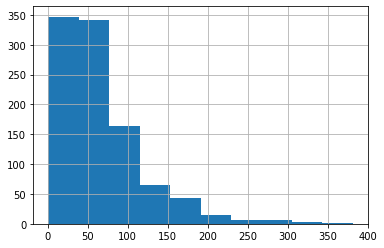

In [36]:
section_df = load_sections_df(f'{PROJECT_DIR}/data/gdsc_train.csv')
nodules = section_df.groupby(['file_name','staining','study']).size().sort_values(ascending=False).reset_index()  # Group the data by nodule image
nodules[0].hist()

In [37]:
display(nodules.head(5))
fraction = len(nodules[nodules[0] > 100])/float(len(nodules))
print('Fraction >100: {:.1%}'.format(fraction))

,file_name,staining,study,0
0,253_A.jpg,A,Study_2,381
1,294_DD.jpg,DD,Study_3,336
2,294_B.jpg,B,Study_3,332
3,294_A.jpg,A,Study_3,331
4,251_A.jpg,A,Study_2,291


Fraction >100: 19.0%


In [38]:
entry_point = 'kaustubh_training.py'
exp_name = entry_point.split('.')[0].replace('_', '-')  # AWS does not allow . and _ as experiment names
account_id = boto3.client('sts').get_caller_identity().get('Account')
role = get_execution_role()
sm_client = boto3.client("sagemaker", region_name=DEFAULT_REGION)
sess = Session(sagemaker_client=sm_client)
s3_output_location = f"s3://{sess.default_bucket()}/{exp_name}"
input_channels = {"train": f"s3://{your_bucket_name}"}
hyperparameters = extract_hyperparams(entry_point) # custom function to parse the training script and extract config
hyperparameters['base_file'] = base_file

metrics = [
    {"Name": "train:loss_rpn_cls", "Regex": "loss_rpn_cls: ([0-9\.]+)"},
    {"Name": "train:loss_rpn_bbox", "Regex": "loss_rpn_bbox: ([0-9\.]+)"},
    {"Name": "train:loss_cls", "Regex": "loss_cls: ([0-9\.]+)"},
    {"Name": "train:loss_bbox", "Regex": "loss_bbox: ([0-9\.]+)"},
    {"Name": "train:loss", "Regex": "loss: ([0-9\.]+)"},
    {"Name": "train:accuracy", "Regex": "acc: ([0-9\.]+)"},
    {"Name": "train:epoch", "Regex": "Epoch (\[[0-9\.]+\])"},
    {"Name": "val:epoch", "Regex": "Epoch\(val\) (\[[0-9]+\])"},
    {"Name": "val:mAP", "Regex": "mAP: ([0-9\.]+)"},
]

estimator = PyTorch(
    entry_point=entry_point,             # This function will be called by the training job
    source_dir="../src",                 # All code in this folder will be copied over
    image_uri=f"954362353459.dkr.ecr.{DEFAULT_REGION}.amazonaws.com/sm-training-custom:torch-1.8.1-cu111-noGPL",
    role=role,
    output_path=s3_output_location,
    container_log_level=20,             # 10=debug, 20=info
    base_job_name=exp_name,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",     # a GPU instance
    volume_size=45,
    metric_definitions=metrics,
    hyperparameters=hyperparameters,
)

In [13]:
estimator.fit(
    input_channels,
    wait=False,           # Whether or not the notebook should wait for the job to finish. By setting it to False we can continue working while the job runs on another machine.
)

# save the name of the experiment to the filesystem so that we can use it later
experiment_name = estimator._hyperparameters["sagemaker_job_name"]

with open(f'{PROJECT_DIR}/kaustubhfinal.txt', 'w+') as f:
    f.write(experiment_name)

2022-08-13 11:07:24,746 - sagemaker.image_uris - INFO - Defaulting to the only supported framework/algorithm version: latest.
2022-08-13 11:07:24,771 - sagemaker.image_uris - INFO - Ignoring unnecessary instance type: None.
2022-08-13 11:07:25,016 - sagemaker - INFO - Creating training-job with name: kaustubh-training-2022-08-13-11-07-24-741


In [39]:
# read the experiment name from the filesystem
with open(f'{PROJECT_DIR}/kaustubhfinal.txt', 'r') as f:
    experiment_name = f.read()
    

model_location = f'{s3_output_location}/{experiment_name}/output/model.tar.gz'
local_model_dir = download_and_extract_model(model_uri=model_location, local_dir='data')

In [17]:
experiment_name

'kaustubh-training-2022-08-12-16-23-54-632'

In [40]:
prediction_df_train = pd.read_csv(f'{data_folder}/{experiment_name}/results_tutorial5_train_epoch_13.csv', sep=';')
prediction_df_train

,section_id,file_name,xmin,ymin,xmax,ymax,detection_score
0,102_A.jpg@1609-2040-1455-1790,102_A.jpg,1609,1455,2040,1790,0.996335
1,102_A.jpg@3360-4251-2764-3150,102_A.jpg,3360,2764,4251,3150,0.996013
2,102_A.jpg@3208-3545-5441-6378,102_A.jpg,3208,5441,3545,6378,0.995954
3,102_A.jpg@3723-4114-4890-5432,102_A.jpg,3723,4890,4114,5432,0.994884
4,102_A.jpg@2847-3361-2149-2519,102_A.jpg,2847,2149,3361,2519,0.994487
...,...,...,...,...,...,...,...
89230,9_D.jpg@2763-2878-576-727,9_D.jpg,2763,576,2878,727,0.079299
89231,9_D.jpg@3016-3093-1469-1602,9_D.jpg,3016,1469,3093,1602,0.077970
89232,9_D.jpg@2279-2526-6059-6472,9_D.jpg,2279,6059,2526,6472,0.077549
89233,9_D.jpg@1716-2483-4692-5311,9_D.jpg,1716,4692,2483,5311,0.069088


In [41]:
ground_truth = load_sections_df(f'{data_folder}/gdsc_train.csv')

evaluator = PredictionEvaluator(ground_truth)
thresholds = [0.5, 0.6, 0.7]
get_leaderboard_score(prediction_df_train, thresholds, evaluator)

2022-08-14 06:14:42,519 - gdsc_score - INFO - Computing results for threshold: 0.5
2022-08-14 06:14:42,520 - PredictionEvaluator - INFO - Matching sections


100%|██████████| 994/994 [01:21<00:00, 12.24it/s]

2022-08-14 06:16:03,794 - PredictionEvaluator - INFO - Merging matched sections
2022-08-14 06:16:03,923 - PredictionEvaluator - INFO - Done matching sections
2022-08-14 06:16:03,927 - PredictionEvaluator - INFO - Evaluating predictions


2022-08-14 06:16:03,928 - PredictionEvaluator - INFO - Computing overall scores
2022-08-14 06:16:03,940 - gdsc_score - INFO - Computing results for threshold: 0.6
2022-08-14 06:16:03,941 - PredictionEvaluator - INFO - Matching sections


100%|██████████| 994/994 [01:20<00:00, 12.37it/s]

2022-08-14 06:17:24,324 - PredictionEvaluator - INFO - Merging matched sections


2022-08-14 06:17:24,456 - PredictionEvaluator - INFO - Done matching sections
2022-08-14 06:17:24,464 - PredictionEvaluator - INFO - Evaluating predictions
2022-08-14 06:17:24,465 - PredictionEvaluator - INFO - Computing overall scores
2022-08-14 06:17:24,477 - gdsc_score - INFO - Computing results for threshold: 0.7
2022-08-14 06:17:24,478 - PredictionEvaluator - INFO - Matching sections


100%|██████████| 994/994 [01:20<00:00, 12.36it/s]

2022-08-14 06:18:44,965 - PredictionEvaluator - INFO - Merging matched sections


2022-08-14 06:18:45,097 - PredictionEvaluator - INFO - Done matching sections
2022-08-14 06:18:45,105 - PredictionEvaluator - INFO - Evaluating predictions
2022-08-14 06:18:45,106 - PredictionEvaluator - INFO - Computing overall scores


{'detection_acc@iou0.5': 69.21,
 'detection_tp@iou0.5': 63443,
 'detection_fp@iou0.5': 25974,
 'detection_fn@iou0.5': 2244,
 'detection_acc@iou0.6': 66.53,
 'detection_tp@iou0.6': 61930,
 'detection_fp@iou0.6': 27405,
 'detection_fn@iou0.6': 3757,
 'detection_acc@iou0.7': 59.94,
 'detection_tp@iou0.7': 58080,
 'detection_fp@iou0.7': 31206,
 'detection_fn@iou0.7': 7607,
 'score': 195.68}

In [42]:
# get score on train prediction with detection score above 0.45
get_leaderboard_score(prediction_df_train[prediction_df_train.detection_score>0.45], thresholds, evaluator)

2022-08-14 06:18:45,139 - gdsc_score - INFO - Computing results for threshold: 0.5
2022-08-14 06:18:45,140 - PredictionEvaluator - INFO - Matching sections


100%|██████████| 994/994 [01:18<00:00, 12.61it/s]

2022-08-14 06:20:04,001 - PredictionEvaluator - INFO - Merging matched sections
2022-08-14 06:20:04,123 - PredictionEvaluator - INFO - Done matching sections
2022-08-14 06:20:04,128 - PredictionEvaluator - INFO - Evaluating predictions
2022-08-14 06:20:04,129 - PredictionEvaluator - INFO - Computing overall scores


2022-08-14 06:20:04,140 - gdsc_score - INFO - Computing results for threshold: 0.6
2022-08-14 06:20:04,141 - PredictionEvaluator - INFO - Matching sections


100%|██████████| 994/994 [01:19<00:00, 12.49it/s]

2022-08-14 06:21:23,785 - PredictionEvaluator - INFO - Merging matched sections


2022-08-14 06:21:23,902 - PredictionEvaluator - INFO - Done matching sections
2022-08-14 06:21:23,909 - PredictionEvaluator - INFO - Evaluating predictions
2022-08-14 06:21:23,910 - PredictionEvaluator - INFO - Computing overall scores
2022-08-14 06:21:23,922 - gdsc_score - INFO - Computing results for threshold: 0.7
2022-08-14 06:21:23,923 - PredictionEvaluator - INFO - Matching sections


100%|██████████| 994/994 [01:19<00:00, 12.55it/s]

2022-08-14 06:22:43,169 - PredictionEvaluator - INFO - Merging matched sections


2022-08-14 06:22:43,281 - PredictionEvaluator - INFO - Done matching sections
2022-08-14 06:22:43,288 - PredictionEvaluator - INFO - Evaluating predictions
2022-08-14 06:22:43,291 - PredictionEvaluator - INFO - Computing overall scores


{'detection_acc@iou0.5': 84.76,
 'detection_tp@iou0.5': 61514,
 'detection_fp@iou0.5': 6891,
 'detection_fn@iou0.5': 4173,
 'detection_acc@iou0.6': 81.59,
 'detection_tp@iou0.6': 60201,
 'detection_fp@iou0.6': 8101,
 'detection_fn@iou0.6': 5486,
 'detection_acc@iou0.7': 73.79,
 'detection_tp@iou0.7': 56869,
 'detection_fp@iou0.7': 11385,
 'detection_fn@iou0.7': 8818,
 'score': 240.14000000000004}

In [44]:
prediction_df_test = pd.read_csv(f'{data_folder}/{experiment_name}/results_tutorial5_test_epoch_13.csv', sep=';')
restricted_prediction_df = prediction_df-test[prediction_df_test.detection_score>0.47]
restricted_prediction_df.to_csv(f'final_submission.csv', sep=';', index = False)

In [50]:
restricted_prediction_df.shape

(4692, 8)

In [21]:
restricted_prediction_df = restricted_prediction_df.drop_duplicates()

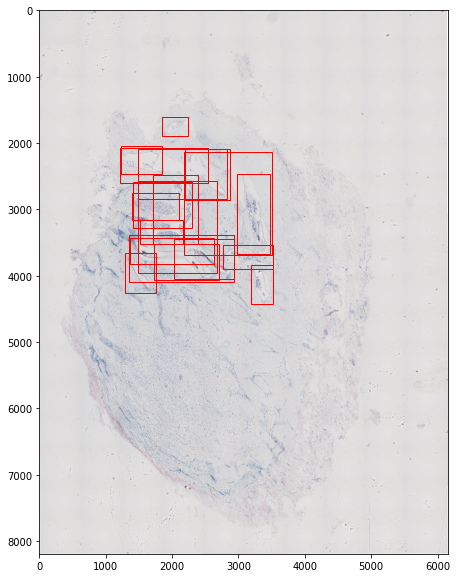

In [36]:
image_worm_sections = prediction_df_test[prediction_df_test.file_name == '92_A.jpg']
import matplotlib.pyplot as plt
from PIL import Image 
from matplotlib.patches import Rectangle

img = Image.open(f'../data/jpgs/92_A.jpg')
plt.figure(figsize=(10,10))  # Set the size of the image
plt.imshow(img)  # Show the image
ax = plt.gca()  # Get the axis

# Draw the boxes for all worm sections
for row in image_worm_sections.itertuples():
    # Create a Rectangle patch
    width = row.xmax - row.xmin
    height = row.ymax - row.ymin
    rect = Rectangle((row.xmin,row.ymin),width,height,linewidth=1,edgecolor='r',facecolor='none')  # define rectangle
    ax.add_patch(rect)  # Add the rectangle to the axis    